In [1]:
%tensorflow_version 2.x

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import numpy as np
import pandas as pd
import cv2
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn.model_selection import GridSearchCV
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

TensorFlow 2.x selected.


In [2]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.4MB 3.4MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 1.2 MB/s 
     |████████████████████████████████| 118 kB 7.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=a32afefe0662f42b582ca69bdd2e296fef478e584023dba929b5041ee046b356
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.13.0 which is incompatible.
ERROR: datascience 0.10.6 has

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [3]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
import json
token = {'username':'suhailhussain','key':'95c46615054d856beb9570b0917dd261'}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [5]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c plant-seedlings-classification

100% 1.68G/1.69G [00:11<00:00, 37.9MB/s]
100% 1.69G/1.69G [00:11<00:00, 155MB/s] 


In [8]:
!unzip {/content}/competitions/plant-seedlings-classification/plant-seedlings-classification.zip

Archive:  {/content}/competitions/plant-seedlings-classification/plant-seedlings-classification.zip
  inflating: sample_submission.csv   
  inflating: test/0021e90e4.png      
  inflating: test/003d61042.png      
  inflating: test/007b3da8b.png      
  inflating: test/0086a6340.png      
  inflating: test/00c47e980.png      
  inflating: test/00d090cde.png      
  inflating: test/00ef713a8.png      
  inflating: test/01291174f.png      
  inflating: test/026716f9b.png      
  inflating: test/02cfeb38d.png      
  inflating: test/03566743d.png      
  inflating: test/03a2ee656.png      
  inflating: test/03e322a29.png      
  inflating: test/03ef36742.png      
  inflating: test/043449b0b.png      
  inflating: test/0437393b1.png      
  inflating: test/04814f36d.png      
  inflating: test/05341a8a6.png      
  inflating: test/060450d79.png      
  inflating: test/060f1dc84.png      
  inflating: test/0625f063b.png      
  inflating: test/063363305.png      
  inflating: test/06d12f6f

In [9]:
!ls

'{'   sample_data   sample_submission.csv   test   train


In [0]:
classes = os.listdir("train")

In [11]:
classes

['Charlock',
 'Loose Silky-bent',
 'Black-grass',
 'Common wheat',
 'Scentless Mayweed',
 'Sugar beet',
 'Maize',
 'Small-flowered Cranesbill',
 'Cleavers',
 'Fat Hen',
 'Common Chickweed',
 'Shepherds Purse']

In [0]:
all_images_class = [os.listdir("train/"+c) for c in classes]
int_to_classes = {i:classes[i] for i in range(len(classes))}
classes_to_int = {classes[i]:i for i in range(len(classes))}

In [13]:
x = [len(x) for x in all_images_class]
x

[390, 654, 263, 221, 516, 385, 221, 496, 287, 475, 611, 231]

In [0]:
df = pd.DataFrame({"n_images": [len(x) for x in all_images_class]}, index=classes)
df.index.name = "Species"

Quick data exploration

In [15]:
df

,n_images
Species,
Charlock,390
Loose Silky-bent,654
Black-grass,263
Common wheat,221
Scentless Mayweed,516
Sugar beet,385
Maize,221
Small-flowered Cranesbill,496
Cleavers,287


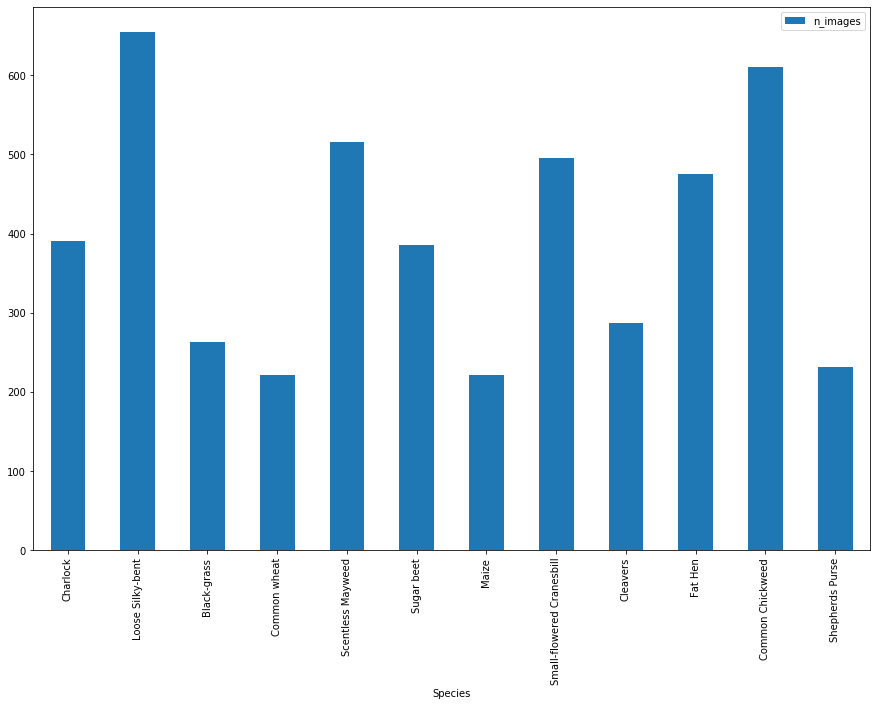

In [16]:
df.plot(kind="bar", figsize=(15,10))

In [0]:
from PIL import Image

Saving all the individual folder names into a list variable "classes"

In [0]:
from subprocess import check_output
classes = check_output(["ls", "train"]).decode("utf8").strip().split("\n")


saving image file name into a list variable files and saving that in a lost variable dir_list

In [0]:
dir_list = []
for c in classes:
    files = check_output(["ls", "train/%s" % c]).decode("utf8").strip().split("\n")
    dir_list.append(files)
    files = check_output(["ls", "-l", "train/%s" % c]).decode("utf8").strip().split("\n")

Putting images inside lists and creating a dataframe with image name, class, height and width

In [0]:
images = []
im_class = []
im_height = []
im_width = []
for c, files in zip(classes, dir_list):
    for img in files:
        im = Image.open("train/%s/%s" % (c, img))
        images.append(img)
        im_class.append(c)
        im_height.append(im.height)
        im_width.append(im.width)

df_all = pd.DataFrame({"class": im_class, "height": im_height, "width": im_width}, index=images)

In [21]:
df_all.head()

,class,height,width
0050f38b3.png,Black-grass,196,196
0183fdf68.png,Black-grass,388,388
0260cffa8.png,Black-grass,886,886
05eedce4d.png,Black-grass,117,117
075d004bc.png,Black-grass,471,471


Checking aspect ratio of all the images and calculating the mean and standard deviation

In [22]:
a_ratio = df_all.height.astype("float") / df_all.width.astype("float")
print(a_ratio.mean(), a_ratio.std())

0.9997113672229471 0.008080359532267326


The mean aspect ratio is almost 1 and the SD is pretty close to 0

Adding aspect ratio to the dataframe

In [0]:
df_all["a_ratio"] = a_ratio

Plotting height and aspect ratio of all the images to see the distribution

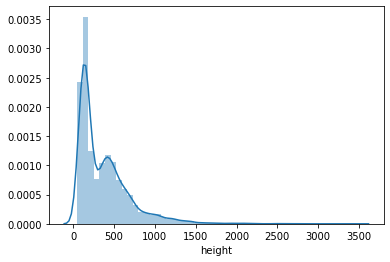

In [24]:
sns.distplot(df_all.height)

There is a slight variance among height in images

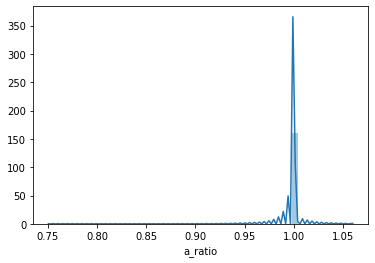

In [25]:
sns.distplot(df_all.a_ratio)

There is very slight variance for aspect ratio

Reading images into images_per_class and resizing to 70*70

In [0]:
seed = 7
scale = 70

In [27]:
path_to_images = 'train/*/*.png'
images = glob(path_to_images)
trainingset = []
traininglabels = []
num = len(images)
count = 1
for i in images:
    print(str(count)+'/'+str(num),end='\r')
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    traininglabels.append(i.split('/')[-2])
    count=count+1
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

Adding Mask

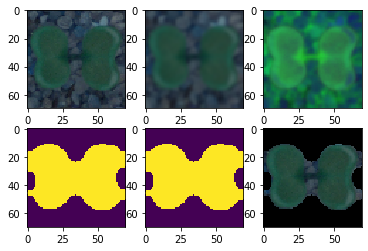

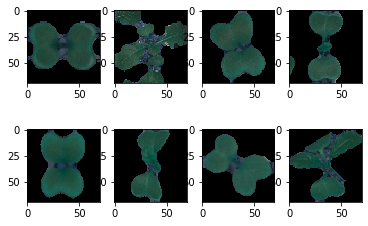

In [28]:
new_train = []
sets = []; getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

Encoding labels to category

In [29]:
labels = LabelEncoder()
labels.fit(traininglabels[0])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


Splitting data into test train split

In [0]:
new_train = new_train/255
X_train,X_test,y_train,y_test = train_test_split(new_train,clearalllabels,test_size=0.1,random_state=seed,stratify=clearalllabels)

Building model

In [0]:
np.random.seed(seed)

model = Sequential()


model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 128)       2

In [0]:
lrr = ReduceLROnPlateau(monitor='val_acc', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.00001)

In [0]:
callbacks_list = [lrr]

In [0]:
model.fit(X_train, y_train, epochs = 50, batch_size=32)

Train on 4275 samples
Epoch 1/50
4275/4275 [==============================] - 12s 3ms/sample - loss: 2.6983 - accuracy: 0.3256
Epoch 2/50
4275/4275 [==============================] - 4s 825us/sample - loss: 1.7206 - accuracy: 0.4821
Epoch 3/50
4275/4275 [==============================] - 4s 847us/sample - loss: 1.4035 - accuracy: 0.5570
Epoch 4/50
4275/4275 [==============================] - 4s 833us/sample - loss: 1.1212 - accuracy: 0.6330
Epoch 5/50
4275/4275 [==============================] - 4s 825us/sample - loss: 0.8830 - accuracy: 0.7123
Epoch 6/50
4275/4275 [==============================] - 4s 831us/sample - loss: 0.8133 - accuracy: 0.7312
Epoch 7/50
4275/4275 [==============================] - 4s 838us/sample - loss: 0.7114 - accuracy: 0.7654
Epoch 8/50
4275/4275 [==============================] - 4s 833us/sample - loss: 0.5821 - accuracy: 0.8075
Epoch 9/50
4275/4275 [==============================] - 4s 833us/sample - loss: 0.5023 - accuracy: 0.8234
Epoch 10/50
4275/4275 [==

In [0]:
model.evaluate(X_test, y_test)

475/475 [==============================] - 1s 1ms/sample - loss: 2.4902 - accuracy: 0.6568


[2.490153509441175, 0.6568421]

The model has overfit with an accuracy of 65% on test while getting 98% on train

In [0]:
y_pred = model.predict(X_test)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 

cmatrix = classification_report(y_check, y_class)
print(cmatrix)

              precision    recall  f1-score   support

           0       0.25      0.15      0.19        26
           1       0.92      0.28      0.43        39
           2       0.92      0.41      0.57        29
           3       0.75      0.90      0.82        61
           4       0.43      0.41      0.42        22
           5       0.55      0.87      0.67        47
           6       0.62      0.85      0.72        65
           7       0.52      0.68      0.59        22
           8       0.72      0.60      0.65        52
           9       0.48      0.87      0.62        23
          10       0.90      0.72      0.80        50
          11       1.00      0.59      0.74        39

    accuracy                           0.66       475
   macro avg       0.67      0.61      0.60       475
weighted avg       0.70      0.66      0.64       475



Predicting on test

In [0]:
path_to_test = 'test/*.png'
pics = glob(path_to_test)

testimages = []
tests = []
count=1
num = len(pics)

for i in pics:
    print(str(count)+'/'+str(num),end='\r')
    tests.append(i.split('/')[-1])
    testimages.append(cv2.resize(cv2.imread(i),(scale,scale)))
    count = count + 1

testimages = np.asarray(testimages)

In [0]:
len(testimages)

794

Applying same mask on test

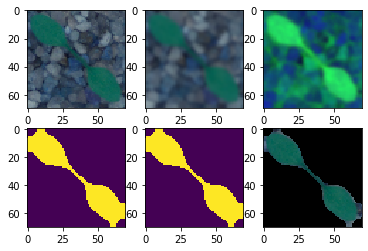

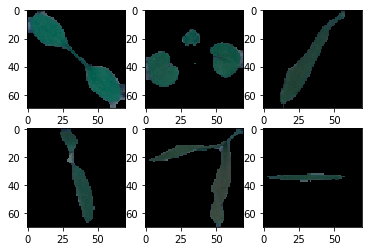

In [0]:
newtestimages = []
sets = []
getEx = True
for i in testimages:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    masking = np.zeros_like(i,np.uint8)
    masking[boolean] = i[boolean]
    newtestimages.append(masking)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i)
        plt.subplot(2,3,2);plt.imshow(blurr)
        plt.subplot(2,3,3);plt.imshow(hsv)
        plt.subplot(2,3,4);plt.imshow(mask)
        plt.subplot(2,3,5);plt.imshow(boolean)
        plt.subplot(2,3,6);plt.imshow(masking)
        plt.show()
        getEx=False

newtestimages = np.asarray(newtestimages)
# OTHER MASKED IMAGES
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(newtestimages[i])

In [0]:
newtestimages=newtestimages/255
prediction = model.predict(newtestimages)

In [0]:
pred = np.argmax(prediction,axis=1)
predStr = labels.classes_[pred]

pred

array([ 3, 10,  6,  8,  4,  6,  6,  9,  1, 10,  4,  4,  3,  5,  1,  5,  6,
        8,  8,  9,  3,  3,  7,  6,  3,  0,  9, 11,  6,  4,  5,  8,  9,  5,
        6,  5,  8,  1,  8,  2,  9,  3, 10,  6, 10,  6, 11,  7,  3,  4, 11,
        7,  8,  6,  5,  2,  5,  4,  6,  3,  0,  9,  1,  6,  8,  3, 10,  3,
        3,  9,  6,  3, 10,  5,  8,  3,  9,  4,  5,  2,  0,  5,  1,  7, 10,
        6,  5,  7,  6,  5,  6,  4,  8,  6,  6,  6,  8,  3, 11,  3,  6,  1,
        4,  3,  1,  5,  4, 10,  3,  6, 11,  5,  2, 11, 10,  9, 11,  6,  9,
        0,  3,  6,  3,  5,  9,  6,  3,  3,  6,  5,  3, 11,  0,  9,  9, 11,
        7,  7,  8,  7,  9,  1, 10,  3,  6,  7, 10,  7, 10,  9,  6,  8,  9,
        8,  8,  8,  9,  8, 10,  3, 10,  6,  6,  1,  9,  9,  6,  2, 10,  6,
        5,  3,  9,  8,  0,  3,  6, 10, 10,  9,  3,  8,  9,  0,  9,  0, 10,
       10,  5,  4, 10,  8,  6,  0, 10,  8,  3,  6,  7,  3,  7, 11, 10,  7,
        6,  5, 10,  4,  3,  9,  6,  0,  6,  3,  3,  3,  3,  4,  5,  9,  5,
        3,  7,  5,  8, 11

Trying grid search

In [0]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.1))
    model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    

In [0]:
model = KerasClassifier(build_fn=create_model)

Finding optimum number of epochs and batch size

In [0]:
lrr = ReduceLROnPlateau(monitor='val_acc', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.00001)

In [0]:
#callbacks_list = [lrr]
X = new_train
y = clearalllabels
batch_size = [64, 128]
epochs = [75, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=2)
grid_result = grid.fit(X_train, y_train)

Train on 2137 samples
Epoch 1/75
2137/2137 [==============================] - 10s 5ms/sample - loss: 3.4649 - accuracy: 0.2723
Epoch 2/75
2137/2137 [==============================] - 1s 701us/sample - loss: 1.8994 - accuracy: 0.4052
Epoch 3/75
2137/2137 [==============================] - 1s 700us/sample - loss: 1.6539 - accuracy: 0.4717
Epoch 4/75
2137/2137 [==============================] - 1s 699us/sample - loss: 1.3312 - accuracy: 0.5606
Epoch 5/75
2137/2137 [==============================] - 1s 700us/sample - loss: 1.1767 - accuracy: 0.6228
Epoch 6/75
2137/2137 [==============================] - 2s 703us/sample - loss: 0.9616 - accuracy: 0.6860
Epoch 7/75
2137/2137 [==============================] - 2s 712us/sample - loss: 0.8773 - accuracy: 0.7075
Epoch 8/75
2137/2137 [==============================] - 2s 703us/sample - loss: 0.7663 - accuracy: 0.7403
Epoch 9/75
2137/2137 [==============================] - 1s 700us/sample - loss: 0.5879 - accuracy: 0.7922
Epoch 10/75
2137/2137 [==

In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.706428 using {'batch_size': 64, 'epochs': 100}
0.705725 (0.024396) with: {'batch_size': 64, 'epochs': 75}
0.706428 (0.021355) with: {'batch_size': 64, 'epochs': 100}
0.693564 (0.014107) with: {'batch_size': 128, 'epochs': 75}
0.705497 (0.000165) with: {'batch_size': 128, 'epochs': 100}


Finding optimum optimizer

In [0]:
def create_model(optimizer='Adam'):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.1))
    model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [0]:
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=64)

In [0]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=3)
grid_result = grid.fit(X_train, y_train)

Train on 2850 samples
Epoch 1/100
2850/2850 [==============================] - 4s 1ms/sample - loss: 2.0748 - accuracy: 0.3418
Epoch 2/100
2850/2850 [==============================] - 2s 703us/sample - loss: 1.3720 - accuracy: 0.5211
Epoch 3/100
2850/2850 [==============================] - 2s 710us/sample - loss: 1.1112 - accuracy: 0.6112
Epoch 4/100
2850/2850 [==============================] - 2s 701us/sample - loss: 0.9270 - accuracy: 0.6832
Epoch 5/100
2850/2850 [==============================] - 2s 709us/sample - loss: 0.7355 - accuracy: 0.7414
Epoch 6/100
2850/2850 [==============================] - 2s 706us/sample - loss: 0.6290 - accuracy: 0.7754
Epoch 7/100
2850/2850 [==============================] - 2s 701us/sample - loss: 0.5368 - accuracy: 0.8165
Epoch 8/100
2850/2850 [==============================] - 2s 698us/sample - loss: 0.4504 - accuracy: 0.8474
Epoch 9/100
2850/2850 [==============================] - 2s 704us/sample - loss: 0.3970 - accuracy: 0.8561
Epoch 10/100
2850

In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.788538 using {'optimizer': 'SGD'}
0.788538 (0.002316) with: {'optimizer': 'SGD'}
0.743158 (0.013906) with: {'optimizer': 'RMSprop'}
0.783392 (0.006641) with: {'optimizer': 'Adagrad'}
0.625263 (0.026893) with: {'optimizer': 'Adadelta'}
0.638363 (0.106323) with: {'optimizer': 'Adam'}
0.750877 (0.031263) with: {'optimizer': 'Adamax'}
0.738947 (0.033864) with: {'optimizer': 'Nadam'}


Finding optimum learning rate and momentum

In [0]:
from tensorflow.keras.optimizers import SGD
def create_model(learn_rate=0.01, momentum=0):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.1))
    model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(classes, activation='softmax'))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model



In [0]:
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=64)

In [0]:
learn_rate = [0.001, 0.01, 0.5, 0.1]
momentum = [0.0, 0.2, 0.4, 0.6]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=3)
grid_result = grid.fit(X_train, y_train)

Train on 2850 samples
Epoch 1/100
2850/2850 [==============================] - 3s 966us/sample - loss: 2.5125 - accuracy: 0.2260
Epoch 2/100
2850/2850 [==============================] - 2s 728us/sample - loss: 1.9069 - accuracy: 0.3702
Epoch 3/100
2850/2850 [==============================] - 2s 732us/sample - loss: 1.6493 - accuracy: 0.4347
Epoch 4/100
2850/2850 [==============================] - 2s 725us/sample - loss: 1.4852 - accuracy: 0.4989
Epoch 5/100
2850/2850 [==============================] - 2s 727us/sample - loss: 1.3491 - accuracy: 0.5354
Epoch 6/100
2850/2850 [==============================] - 2s 729us/sample - loss: 1.2904 - accuracy: 0.5691
Epoch 7/100
2850/2850 [==============================] - 2s 731us/sample - loss: 1.1950 - accuracy: 0.5975
Epoch 8/100
2850/2850 [==============================] - 2s 733us/sample - loss: 1.1206 - accuracy: 0.6239
Epoch 9/100
2850/2850 [==============================] - 2s 737us/sample - loss: 1.0567 - accuracy: 0.6449
Epoch 10/100
28

In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.790643 using {'learn_rate': 0.01, 'momentum': 0.4}
0.759766 (0.004339) with: {'learn_rate': 0.001, 'momentum': 0.0}
0.772865 (0.002708) with: {'learn_rate': 0.001, 'momentum': 0.2}
0.766316 (0.011757) with: {'learn_rate': 0.001, 'momentum': 0.4}
0.778480 (0.003684) with: {'learn_rate': 0.001, 'momentum': 0.6}
0.757895 (0.035769) with: {'learn_rate': 0.01, 'momentum': 0.0}
0.785029 (0.008993) with: {'learn_rate': 0.01, 'momentum': 0.2}
0.790643 (0.010786) with: {'learn_rate': 0.01, 'momentum': 0.4}
0.789708 (0.005881) with: {'learn_rate': 0.01, 'momentum': 0.6}
0.113450 (0.032616) with: {'learn_rate': 0.5, 'momentum': 0.0}
0.134269 (0.005167) with: {'learn_rate': 0.5, 'momentum': 0.2}
0.134269 (0.005167) with: {'learn_rate': 0.5, 'momentum': 0.4}
0.103392 (0.041144) with: {'learn_rate': 0.5, 'momentum': 0.6}
0.736374 (0.039541) with: {'learn_rate': 0.1, 'momentum': 0.0}
0.434854 (0.292154) with: {'learn_rate': 0.1, 'momentum': 0.2}
0.516725 (0.327746) with: {'learn_rate': 0.1, '

Finding optimum activation function

In [0]:
def create_model(activation='relu'):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation=activation))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation=activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization(axis=3))
    model.add(Dropout(0.1))
    model.add(Conv2D(filters=128, kernel_size=(5, 5), activation=activation))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(256, activation=activation))
    model.add(Dropout(0.2))

    model.add(Dense(256, activation=activation))
    model.add(Dropout(0.2))

    model.add(Dense(classes, activation='softmax'))
    optimizer = SGD(lr=0.01, momentum=0.4)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [0]:
model = KerasClassifier(build_fn=create_model, epochs=64, batch_size=100)

In [0]:
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_train, y_train)


Train on 3420 samples
Epoch 1/64
3420/3420 [==============================] - 7s 2ms/sample - loss: 2.4818 - accuracy: 0.1257
Epoch 2/64
3420/3420 [==============================] - 4s 1ms/sample - loss: 2.4760 - accuracy: 0.1377
Epoch 3/64
3420/3420 [==============================] - 4s 1ms/sample - loss: 2.4708 - accuracy: 0.1377
Epoch 4/64
3420/3420 [==============================] - 4s 1ms/sample - loss: 2.4660 - accuracy: 0.1377
Epoch 5/64
3420/3420 [==============================] - 4s 1ms/sample - loss: 2.4617 - accuracy: 0.1377
Epoch 6/64
3420/3420 [==============================] - 4s 1ms/sample - loss: 2.4578 - accuracy: 0.1377
Epoch 7/64
3420/3420 [==============================] - 4s 1ms/sample - loss: 2.4544 - accuracy: 0.1377
Epoch 8/64
3420/3420 [==============================] - 4s 1ms/sample - loss: 2.4512 - accuracy: 0.1377
Epoch 9/64
3420/3420 [==============================] - 4s 1ms/sample - loss: 2.4483 - accuracy: 0.1377
Epoch 10/64
3420/3420 [===================

In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.783626 using {'activation': 'relu'}
0.137778 (0.004873) with: {'activation': 'softmax'}
0.767251 (0.021943) with: {'activation': 'softplus'}
0.758363 (0.021851) with: {'activation': 'softsign'}
0.783626 (0.012662) with: {'activation': 'relu'}
0.763743 (0.024511) with: {'activation': 'tanh'}
0.721404 (0.037656) with: {'activation': 'sigmoid'}
0.723977 (0.013720) with: {'activation': 'hard_sigmoid'}
0.672281 (0.031751) with: {'activation': 'linear'}


Building optimum model

In [33]:
from tensorflow.keras.optimizers import SGD
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(classes, activation='softmax'))
optimizer = SGD(lr=0.01, momentum=0.4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_3 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 128)      

In [0]:
lrr = ReduceLROnPlateau(monitor='val_acc', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.00001)

In [0]:
callbacks_list = [lrr]

In [36]:
model.fit(X_train, y_train, epochs=100, batch_size=64)

Train on 4275 samples
Epoch 1/100
4275/4275 [==============================] - 12s 3ms/sample - loss: 1.8595 - accuracy: 0.3942
Epoch 2/100
4275/4275 [==============================] - 3s 704us/sample - loss: 1.1782 - accuracy: 0.6044
Epoch 3/100
4275/4275 [==============================] - 3s 703us/sample - loss: 0.8899 - accuracy: 0.6959
Epoch 4/100
4275/4275 [==============================] - 3s 706us/sample - loss: 0.7189 - accuracy: 0.7544
Epoch 5/100
4275/4275 [==============================] - 3s 705us/sample - loss: 0.5759 - accuracy: 0.7988
Epoch 6/100
4275/4275 [==============================] - 3s 714us/sample - loss: 0.4878 - accuracy: 0.8229
Epoch 7/100
4275/4275 [==============================] - 3s 707us/sample - loss: 0.4000 - accuracy: 0.8585
Epoch 8/100
4275/4275 [==============================] - 3s 712us/sample - loss: 0.3332 - accuracy: 0.8903
Epoch 9/100
4275/4275 [==============================] - 3s 716us/sample - loss: 0.2891 - accuracy: 0.8992
Epoch 10/100
427

In [37]:
model.evaluate(X_test, y_test)

475/475 [==============================] - 1s 1ms/sample - loss: 0.9991 - accuracy: 0.8253


[0.9991096335963199, 0.82526314]

Optimum model gives an accuracy of 82% on the test set

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_pred = np.argmax(y_pred, axis = 1)

In [0]:
y_check = np.argmax(y_test, axis = 1)

In [0]:
Classification_report()

In [0]:
y_pred = grid.predict(X_test)

In [0]:
y_check = np.argmax(y_test, axis =1)

In [45]:
cmatrix = classification_report(y_check, y_pred)
print(cmatrix)

              precision    recall  f1-score   support

           0       0.29      0.19      0.23        26
           1       0.88      0.90      0.89        39
           2       0.93      0.93      0.93        29
           3       0.90      0.93      0.92        61
           4       0.88      0.64      0.74        22
           5       0.86      0.89      0.88        47
           6       0.72      0.82      0.76        65
           7       0.83      0.86      0.84        22
           8       0.77      0.90      0.83        52
           9       0.78      0.61      0.68        23
          10       0.92      0.92      0.92        50
          11       0.94      0.85      0.89        39

    accuracy                           0.83       475
   macro avg       0.81      0.79      0.79       475
weighted avg       0.82      0.83      0.82       475



Using Fast ai library with resnet 34 

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import matplotlib.pyplot as plt


In [0]:
bs = 64

In [0]:
path = Path('train')
path.ls()

[PosixPath('train/Charlock'),
 PosixPath('train/Loose Silky-bent'),
 PosixPath('train/Black-grass'),
 PosixPath('train/Common wheat'),
 PosixPath('train/Scentless Mayweed'),
 PosixPath('train/Sugar beet'),
 PosixPath('train/Maize'),
 PosixPath('train/Small-flowered Cranesbill'),
 PosixPath('train/Cleavers'),
 PosixPath('train/Fat Hen'),
 PosixPath('train/Common Chickweed'),
 PosixPath('train/Shepherds Purse')]

Splitting data into train and validation into a databunch object

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(),valid_pct=0.25,size=299,bs=32,num_workers=0)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (3563 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Charlock,Charlock,Charlock,Charlock,Charlock
Path: train;

Valid: LabelList (1187 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Fat Hen,Black-grass,Charlock,Sugar beet,Scentless Mayweed
Path: train;

Test: None

In [0]:
print(data.classes)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


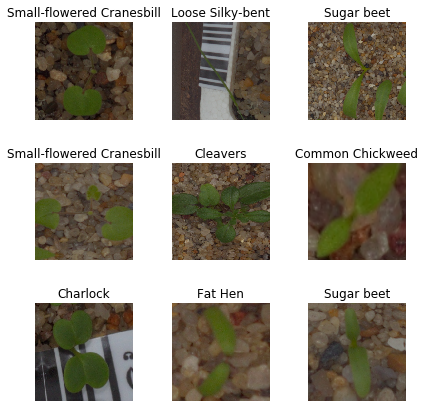

In [0]:
data.show_batch(rows=3,figsize=(6,6))

Using resnet34 architecture

In [0]:
learn = cnn_learner(data,models.resnet34,metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 76.3MB/s]


Quickly fitting the model 

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.784990,0.750129,0.764954,02:31
1,0.883878,0.444974,0.837405,02:38
2,0.568446,0.340874,0.878686,02:39
3,0.438981,0.321889,0.882056,02:29


In [0]:
learn.save('stage-1')

In [0]:
inter = ClassificationInterpretation.from_learner(learn)

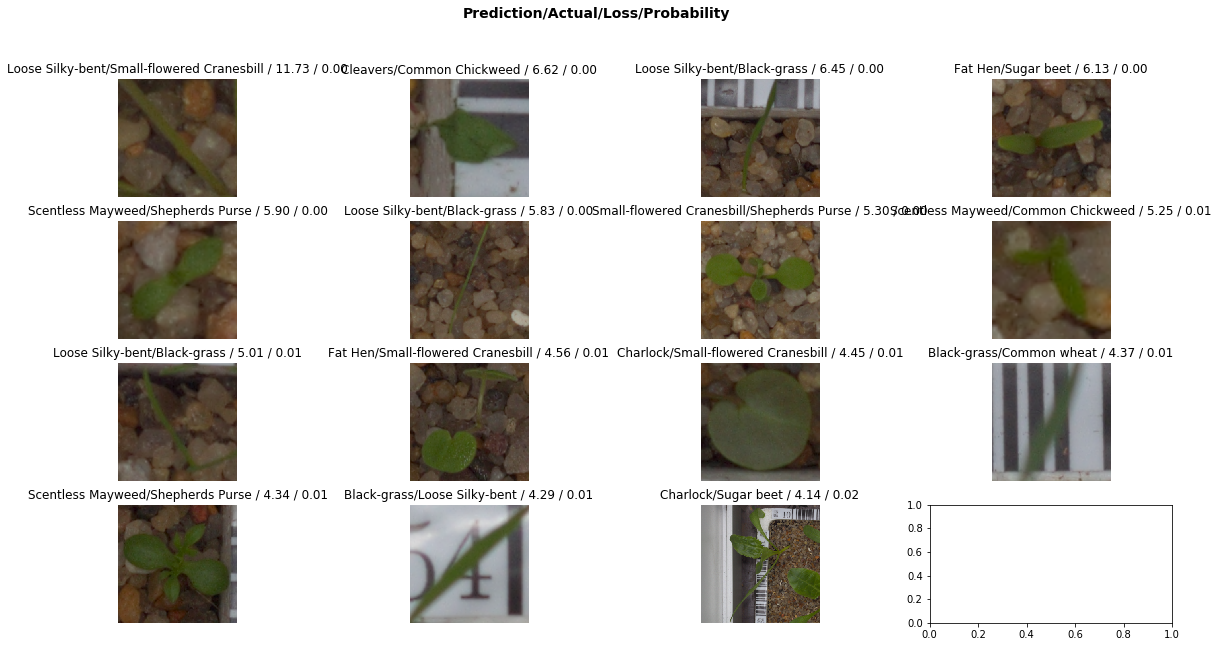

In [0]:
inter.plot_top_losses(15, figsize=(20,10))

In [0]:
inter.most_confused(min_val=2)

[('Black-grass', 'Loose Silky-bent', 39),
 ('Loose Silky-bent', 'Black-grass', 14),
 ('Shepherds Purse', 'Scentless Mayweed', 11),
 ('Sugar beet', 'Fat Hen', 9),
 ('Common Chickweed', 'Scentless Mayweed', 6),
 ('Common wheat', 'Black-grass', 4),
 ('Scentless Mayweed', 'Common Chickweed', 4),
 ('Shepherds Purse', 'Small-flowered Cranesbill', 4),
 ('Common wheat', 'Loose Silky-bent', 3),
 ('Scentless Mayweed', 'Shepherds Purse', 3),
 ('Black-grass', 'Common wheat', 2),
 ('Cleavers', 'Charlock', 2),
 ('Common Chickweed', 'Small-flowered Cranesbill', 2),
 ('Common wheat', 'Sugar beet', 2),
 ('Fat Hen', 'Sugar beet', 2),
 ('Loose Silky-bent', 'Scentless Mayweed', 2),
 ('Scentless Mayweed', 'Loose Silky-bent', 2),
 ('Small-flowered Cranesbill', 'Charlock', 2),
 ('Small-flowered Cranesbill', 'Shepherds Purse', 2)]

Training whole model

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.557423,0.236975,0.912384,02:33


Training whole model even for one epoch gives a better accuracy. Now tuning learning rate

Loading back the original model

In [0]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (3563 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Charlock,Charlock,Charlock,Charlock,Charlock
Path: train;

Valid: LabelList (1187 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Fat Hen,Black-grass,Charlock,Sugar beet,Scentless Mayweed
Path: train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mome

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


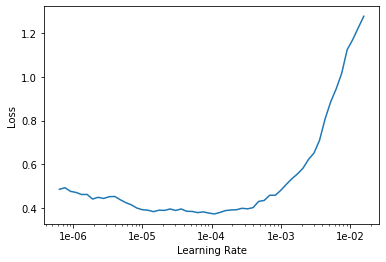

In [0]:
learn.recorder.plot()

Taking the learning rates between 1e-5 to 1e-4 and applying them across the model

In [0]:
learn.unfreeze()
learn.fit_one_cycle(50, max_lr = slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.391378,0.295363,0.893850,02:35
1,0.375098,0.287038,0.892165,02:35
2,0.339344,0.267028,0.903960,02:35
3,0.303426,0.252070,0.914912,02:35
4,0.279145,0.244694,0.913227,02:35
5,0.265998,0.220795,0.922494,02:34
6,0.213338,0.197052,0.931761,02:33
7,0.192411,0.195817,0.934288,02:33
8,0.177754,0.193311,0.936816,02:32
9,0.144140,0.185542,0.938500,02:32


Checking to see top most confused images


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

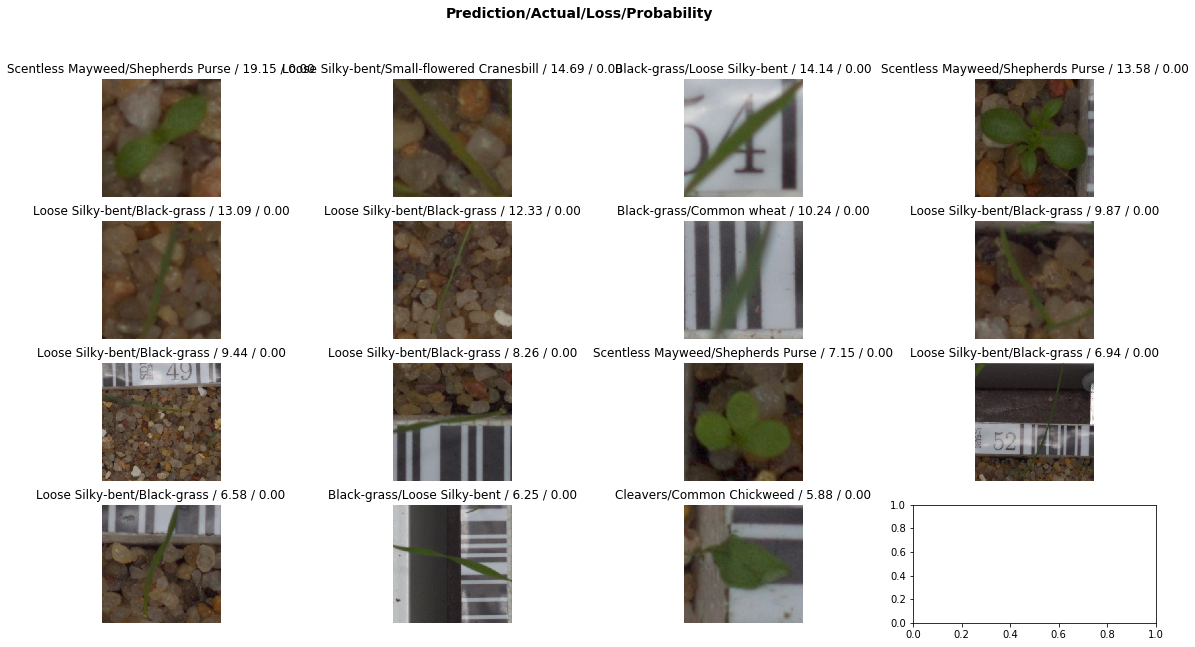

In [0]:
interp.plot_top_losses(15, figsize=(20,10))

In [0]:
interp.most_confused(min_val=2)

[('Black-grass', 'Loose Silky-bent', 23),
 ('Shepherds Purse', 'Scentless Mayweed', 6),
 ('Loose Silky-bent', 'Black-grass', 5),
 ('Scentless Mayweed', 'Common Chickweed', 2)]

Transfer learning using resnet 34 gives an extremely high accuracy of 96%